In [1]:
import os
import sys
# Add the src directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)
from src.data_handling.historical_data_handler import SingleSymbolDataHandler
from src.feature_engineering.feature_extractor import SingleSymbolFeatureExtractor
%cd $project_root

/Users/zhaoyub/Documents/Tradings/tradebotv3


/Users/zhaoyub/Library/Python/3.12/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.8f' % x)
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [12]:
datahandler = SingleSymbolDataHandler('BTCUSDT')
inter, begin, end = '15m', '2023-01-01', '2024-09-24'
datahandler.set_dates(begin, end)
datahandler_incre = datahandler.copy()
datahandler.load_data(inter, begin, end)
BTC_indicator = SingleSymbolFeatureExtractor('BTCUSDT', datahandler)
indicator_incre = SingleSymbolFeatureExtractor('BTCUSDT', datahandler_incre)
start = datahandler.window_size 
# start_index = max(0, start - datahandler.window_size)
datahandler_incre.cleaned_data = datahandler.get_data_range(0, start)
# print(datahandler_incre.cleaned_data.shape)
indicator_incre.pre_run_indicators()
# print(indicator_incre.indicators.shape)
BTC_indicator.load_full_range()
indicators = BTC_indicator.indicators
datahandler.cleaned_data['close'] = datahandler.cleaned_data['close']
indicators = pd.concat([indicators,datahandler.cleaned_data[['close', 'volume']]],axis= 1)


In [13]:
indicator_incre.indicators.shape
print(indicator_incre.indicators.tail(10))
print(indicators[190:200])
print(indicator_incre.indicators.shape)

                                  rsi         macd  macd_signal   macd_diff  \
open_time                                                                     
2023-01-02 23:30:00+00:00 28.20982011  -0.60967887   3.77025110 -4.37992997   
2023-01-02 23:45:00+00:00 11.93092978  -3.39966047   3.08740238 -6.48706285   
2023-01-03 00:00:00+00:00 37.92741422  -4.82311589   2.33401968 -7.15713557   
2023-01-03 00:15:00+00:00 33.74935377  -6.18224983   1.52294640 -7.70519623   
2023-01-03 00:30:00+00:00 64.98918673  -5.98745020   0.80767053 -6.79512073   
2023-01-03 00:45:00+00:00 51.09883779  -6.26297751   0.13427548 -6.39725299   
2023-01-03 01:00:00+00:00 30.71453158  -7.43840529  -0.58693221 -6.85147308   
2023-01-03 01:15:00+00:00 18.28880857  -9.47644977  -1.43355293 -8.04289683   
2023-01-03 01:30:00+00:00 39.42730508 -10.41503899  -2.28893256 -8.12610644   
2023-01-03 01:45:00+00:00 50.93836369 -10.70436776  -3.09040258 -7.61396519   

                              stoch_k     stoch_d  

In [19]:
from tqdm import tqdm

def run_indicator_incremental_update(indicator_extractor, window_size=100):
    """
    Incrementally updates indicators using a sliding window approach,
    mimicking a live trading environment.
    
    Args:
        indicator_extractor (SingleSymbolFeatureExtractor): An instance that has been
            initialized with a data handler containing loaded data.
        window_size (int): The number of recent data points to consider for each update.
        
    Returns:
        pd.DataFrame: A DataFrame containing the indicator snapshots updated incrementally.
    """
    data = datahandler.cleaned_data
    # print("Data length:", len(data))
    # print(window_size)
    incremental_snapshots = []
    
    if len(data) <= window_size:
        print("Not enough data to run incremental updates.")
        return pd.DataFrame()
    
    # Use tqdm to add a progress bar over the range of data indices
    for i in tqdm(range(window_size, len(data)), desc="Updating indicators incrementally"):
        start_index = max(0, i - window_size + 1)
        datahandler_incre.cleaned_data = datahandler.get_data_range(start_index, i+1)
        # print(datahandler_incre.cleaned_data.shape)
        latest_data = datahandler_incre.cleaned_data.iloc[[-1]]
        # print(latest_data)
        if i == 4 * window_size:
            break
        
        # Update the indicator with the latest data point
        indicator_extractor.update(latest_data)
        
        # Retrieve the latest snapshot from the indicator extractor
        try:
            snapshot = indicator_extractor.indicators.iloc[[-1]].copy()
            snapshot.index = [data.index[i]]
            incremental_snapshots.append(snapshot)
        except Exception as e:
            print(f"Error retrieving snapshot at index {i}: {e}")
    
    if not incremental_snapshots:
        print("No snapshots were created during the loop.")
        return pd.DataFrame()
    incremental_indicators_df = pd.concat(incremental_snapshots, axis=0)
    indicator_extractor.indicators = incremental_indicators_df

    
    return incremental_indicators_df


In [20]:
incremental_indicators= run_indicator_incremental_update(indicator_incre, window_size=datahandler.window_size)


Updating indicators incrementally:   0%|          | 0/60464 [00:00<?, ?it/s]

Updating indicators incrementally:   1%|          | 600/60464 [00:01<02:10, 460.43it/s]


In [21]:
incremental_indicators.columns

Index(['rsi', 'macd', 'macd_signal', 'macd_diff', 'stoch_k', 'stoch_d',
       'bollinger_mavg', 'bollinger_upper', 'bollinger_lower', 'atr', 'vwap',
       'obv', 'sma', 'ema', 'adx'],
      dtype='object')

In [22]:
print(incremental_indicators.iloc[0 * datahandler.window_size : 1*datahandler.window_size])
print(indicators.iloc[1*datahandler.window_size :2*datahandler.window_size])

                                  rsi        macd  macd_signal   macd_diff  \
2023-01-03 02:00:00+00:00 83.95073886 -9.35630427  -4.82422311 -4.53208115   
2023-01-03 02:15:00+00:00 53.15674199 -9.64121167  -5.28298393 -4.35822774   
2023-01-03 02:30:00+00:00 66.12137836 -9.29102530  -5.66470215 -3.62632314   
2023-01-03 02:45:00+00:00 44.43198309 -9.52400963  -6.03225525 -3.49175439   
2023-01-03 03:00:00+00:00 38.48029505 -9.82480722  -6.39345067 -3.43135655   
...                               ...         ...          ...         ...   
2023-01-05 02:45:00+00:00 62.96125597 -2.75872901  -1.71346095 -1.04526806   
2023-01-05 03:00:00+00:00 51.45562435 -2.72054785  -1.80937399 -0.91117386   
2023-01-05 03:15:00+00:00 26.13392540 -3.06715320  -1.92916248 -1.13799072   
2023-01-05 03:30:00+00:00 17.91249100 -3.57472006  -2.08588225 -1.48883781   
2023-01-05 03:45:00+00:00 41.44330639 -3.74966616  -2.24433786 -1.50532829   

                              stoch_k     stoch_d  bollinger_ma

<Axes: title={'center': 'RSI Incremental Update'}>

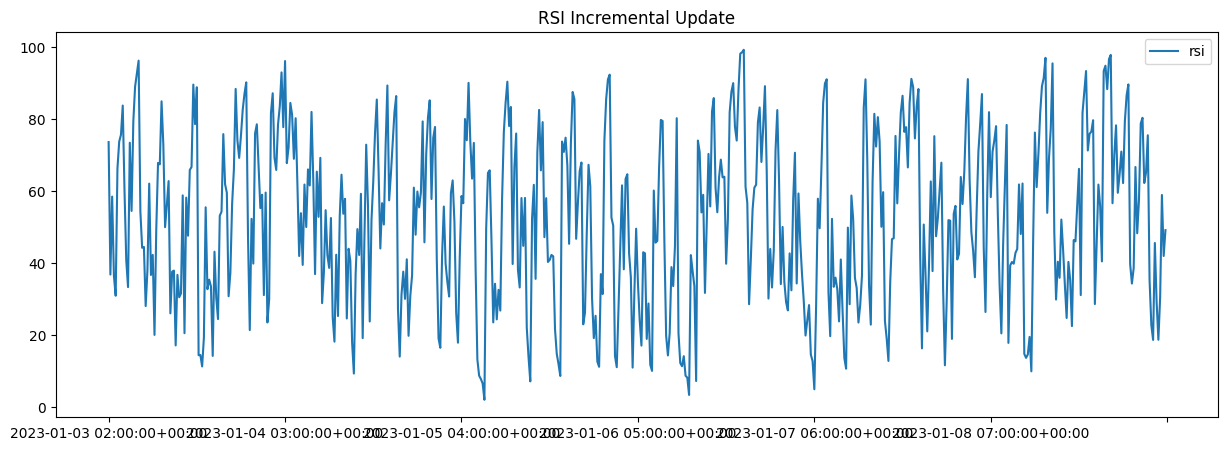

In [91]:
incremental_indicators[['rsi']].plot(figsize=(15, 5), title='RSI Incremental Update')